# N05A - Fully Supervised Training with Parameterised Signals using High-Level Features

## Step 1: Data Loading

- Data is stored in the form of TFRecord files that can be loaded lazily into tensorflow dataset

In [1]:
import os
import glob
import json

import numpy as np
import tensorflow as tf

from aliad.interface.tensorflow.dataset import (apply_pipelines, split_dataset,
                                                get_ndarray_tfrecord_example_parser)

dirname = '/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/tfrecords/'
filenames = glob.glob(os.path.join(dirname, 'SR_*_shuffled_shard_*.tfrec'))
metadata_filename = os.path.join(dirname, 'SR_point_cloud_train_features_all_signals_all_backgrounds_metadata.json')

# metadata contains information about the shape and dtype of each type of features, as well as the size of the dataset
metadata = json.load(open(metadata_filename))

In [2]:
metadata['features']

{'part_coords': {'shape': [2, 300, 2], 'dtype': 'float64'},
 'part_features': {'shape': [2, 300, 4], 'dtype': 'float64'},
 'jet_features': {'shape': [2, 7], 'dtype': 'float64'},
 'part_masks': {'shape': [2, 300], 'dtype': 'bool'},
 'label': {'shape': [1], 'dtype': 'int64'},
 'weight': {'shape': [1], 'dtype': 'float64'},
 'm1': {'shape': [1], 'dtype': 'float64'},
 'm2': {'shape': [1], 'dtype': 'float64'}}

In [3]:
metadata['sample_size']

{'QCD': 121351,
 'extra_QCD': 612853,
 'W_50_450': 72728,
 'W_400_50': 44016,
 'W_500_600': 59319,
 'W_500_250': 68873,
 'W_350_500': 69686,
 'W_250_450': 72477,
 'W_450_350': 70912,
 'W_600_100': 48551,
 'W_50_100': 76327,
 'W_450_500': 67605,
 'W_100_400': 74261,
 'W_450_200': 70539,
 'W_600_300': 62038,
 'W_50_150': 76482,
 'W_500_500': 65754,
 'W_300_250': 74743,
 'W_450_600': 61071,
 'W_50_300': 75557,
 'W_200_500': 71231,
 'W_150_200': 76421,
 'W_500_50': 33154,
 'W_50_50': 75286,
 'W_150_300': 75953,
 'W_100_300': 75777,
 'W_400_450': 70527,
 'W_400_150': 70112,
 'W_100_500': 71493,
 'W_350_50': 49591,
 'W_250_150': 74473,
 'W_100_450': 73157,
 'W_350_250': 73947,
 'W_600_450': 60922,
 'W_150_400': 74239,
 'W_150_50': 70476,
 'W_50_500': 70855,
 'W_200_550': 68501,
 'W_250_600': 64278,
 'W_100_100': 76373,
 'W_400_550': 66384,
 'W_200_200': 75929,
 'W_150_600': 64707,
 'W_150_450': 72899,
 'W_300_500': 70313,
 'W_500_100': 58176,
 'W_550_50': 27970,
 'W_300_400': 73486,
 'W_100_

In [4]:
# method to extract the feature vectors and label from the tfrecord
def get_input(X):
    return X['jet_features'], X['label']

def get_dataset(filenames, base_parse_func, input_parse_func, batch_size):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(base_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(input_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    # datasets pre-shuffled, no need to shuffle again
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

batch_size = 1024
# method for parsing the binary tfrecord into array data
parse_tfrecord_fn = get_ndarray_tfrecord_example_parser(metadata['features'])
# each file contains 100k events and are pre-shuffled, so we just use diferent set of files for train, validation and test
ds_train = get_dataset(filenames[:50], parse_tfrecord_fn, get_input, batch_size=batch_size)
ds_val   = get_dataset(filenames[50:75], parse_tfrecord_fn, get_input, batch_size=batch_size)
ds_test  = get_dataset(filenames[75:100], parse_tfrecord_fn, get_input, batch_size=batch_size)

2023-11-25 02:52:19.221257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-25 02:52:21.138034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 730 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2023-11-25 02:52:21.139543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78353 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-11-25 02:52:21.141007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device

## Step 2: Create simple MLP model

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
model = Sequential([
    Input(**metadata['features']['jet_features']),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [6]:
# total number of train samples
total_size = int(100_000 * 100 * 0.5)
steps_per_epoch = total_size / batch_size
config = {
    # for binary classification
    'loss'       : 'binary_crossentropy',
    'metrics'    : ['accuracy'],
    'epochs'     : 100,
    'optimizer'  : 'Adam',
    'optimizer_config': {
        'learning_rate': 0.001
    },
    'checkpoint_dir': '/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/'
                      'param_high_level_10M_events_SR_v1',
    'callbacks': {
        'lr_scheduler': {
            'initial_lr': 0.001,
            'lr_decay_factor': 0.5,
            'patience': 5,
            'min_lr': 1e-6
        },
        'early_stopping': {
            'monitor': 'val_loss',
            'patience': 3
        },
        'model_checkpoint':{
            'save_weights_only': True,
            # save model checkpoint every epoch
            'save_freq': int(steps_per_epoch * 1)
        }
    }
}

In [7]:
optimizer = tf.keras.optimizers.get({'class_name': config['optimizer'], 'config': config['optimizer_config']})
model.compile(loss=config['loss'],
              optimizer=optimizer,
              metrics=config['metrics'])

### Prepare callbacks

In [8]:
from aliad.interface.tensorflow.callbacks import LearningRateScheduler, BatchMetricsCallback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_dir = config['checkpoint_dir']
import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

lr_scheduler = LearningRateScheduler(**config['callbacks']['lr_scheduler'])

early_stopping = EarlyStopping(**config['callbacks']['early_stopping'])

checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_weights_epoch_{epoch:02d}.h5'),
                             **config['callbacks']['model_checkpoint'])
batch_metrics = BatchMetricsCallback()
callbacks = [lr_scheduler, early_stopping, checkpoint, batch_metrics]

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 256)               3840      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 45,057
Trainable params: 45,057
Non-trainable params: 0
_________________________________________________________________


## Step 3: Train Model

In [10]:
model.fit(ds_train,
          validation_data=ds_val,
          epochs=config['epochs'],
          callbacks=callbacks)

Epoch 1/100


2023-11-23 03:17:40.334896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]
2023-11-23 03:17:40.335368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [50]
	 [[{{node Placeholder/_0}}]]


      6/Unknown - 4s 15ms/step - loss: 0.3482 - accuracy: 0.9321

2023-11-23 03:17:43.902837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   4882/Unknown - 140s 28ms/step - loss: 0.1237 - accuracy: 0.9561

2023-11-23 03:20:02.549240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25]
	 [[{{node Placeholder/_0}}]]
2023-11-23 03:20:02.549746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [25]
	 [[{{node Placeholder/_0}}]]


4882/4882 [==============================] - 213s 43ms/step - loss: 0.1237 - accuracy: 0.9561 - val_loss: 0.1126 - val_accuracy: 0.9594
Epoch 2/100
4882/4882 [==============================] - 189s 39ms/step - loss: 0.1135 - accuracy: 0.9588 - val_loss: 0.1110 - val_accuracy: 0.9599
Epoch 3/100
4882/4882 [==============================] - 185s 38ms/step - loss: 0.1116 - accuracy: 0.9594 - val_loss: 0.1105 - val_accuracy: 0.9600
Epoch 4/100
4882/4882 [==============================] - 168s 34ms/step - loss: 0.1105 - accuracy: 0.9597 - val_loss: 0.1093 - val_accuracy: 0.9603
Epoch 5/100
4882/4882 [==============================] - 201s 41ms/step - loss: 0.1097 - accuracy: 0.9600 - val_loss: 0.1082 - val_accuracy: 0.9606
Epoch 6/100
4882/4882 [==============================] - 187s 38ms/step - loss: 0.1090 - accuracy: 0.9602 - val_loss: 0.1081 - val_accuracy: 0.9605
Epoch 7/100
4882/4882 [==============================] - 191s 39ms/step - loss: 0.1085 - accuracy: 0.9604 - val_loss: 0.1076

In [12]:
# save entire model
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model.save(filename)

In [13]:
# save metrics history from training and evaluation
import json
metrics_history = {
    "train": batch_metrics.batch_train_metrics,
    "val": batch_metrics.batch_val_metrics,
}
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
json.dump(metrics_history, open(filename, "w"))

## Step 4 - Model Testing

In [10]:
filename = os.path.join(config['checkpoint_dir'], "full_train_20_epoch.keras")
model = tf.keras.models.load_model(filename)

### Prediction on the full dataset (25% of 10M events, mixed signals)

In [12]:
import numpy as np
predicted_proba = model.predict(ds_test).flatten()
y_pred = np.round(predicted_proba)
y_true = np.array([y for (x, y) in ds_test]).flatten()

      6/Unknown - 5s 12ms/step

2023-11-24 17:50:47.753992: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2441/2441 [==============================] - 39s 14ms/step


In [39]:
def get_mass_points(filenames, base_parse_func, batch_size):
    ds = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.AUTOTUNE)
    ds = ds.map(base_parse_func, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x: [x['m1'][0], x['m2'][0]])
    ds = apply_pipelines(ds, batch_size=batch_size,
                         shuffle=False, prefetch=True)
    return ds

ds_test_masses = get_mass_points(filenames[75:100], parse_tfrecord_fn, batch_size=batch_size)

mass_points = np.array([d for d in ds_test_masses])

In [58]:
mass_points_  =np.transpose(mass_points, axes=(0, 2, 1))
mass_points_ = mass_points_.reshape((np.product(mass_points_.shape[:-1]), mass_points_.shape[-1]))
m1 = mass_points_[:, 0]
m2 = mass_points_[:, 1]

In [61]:
predicted_results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'm1': m1,
    'm2': m2
}
import pandas as pd
df = pd.DataFrame(predicted_results)

In [65]:
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df.to_parquet(filename, engine='fastparquet')

### Create ROC curves

In [12]:
config['checkpoint_dir']

'/pscratch/sd/c/chlcheng/model_checkpoints/LHCO_AD/fully_supervised/param_high_level_10M_events_SR_v1'

In [8]:
import os
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "prediction.parquet")
df = pd.read_parquet(filename)

In [9]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from scipy.interpolate import interp1d
epsilon = 1e-4

def get_bootstrap_prediction(y_prob, y_true, num_bootstrap_samples:int=20,
                             seed:int=2023):
    np.random.seed(seed)
    bootstrap_y_prob = []
    bootstrap_y_true = []
    sample_size = y_prob.shape[0]
    for _ in range(num_bootstrap_samples):
        # Sampling with replacement
        indices = np.random.choice(sample_size, sample_size, replace=True)
        y_prob_i = y_prob[indices]
        y_true_i = y_true[indices]
        bootstrap_y_prob.append(y_prob_i)
        bootstrap_y_true.append(y_true_i)
    bootstrap_y_prob = np.array(bootstrap_y_prob)
    bootstrap_y_true = np.array(bootstrap_y_true)
    return bootstrap_y_prob, bootstrap_y_true

def compute_median_and_variance_roc_sic(tprs_list, fprs_list, resolution=1000, mean=False):

    # interpolation
    max_min_tpr = 0.
    min_max_tpr = 1.
    for tpr in tprs_list:
        if min(tpr) > max_min_tpr:
            max_min_tpr = min(tpr)
        if max(tpr) < min_max_tpr:
            min_max_tpr = max(tpr)
    tpr_manual = np.linspace(max_min_tpr, min_max_tpr, resolution)

    roc_interpol = []
    sic_interpol = []
    for tpr, fpr in zip(tprs_list, fprs_list):
        roc_function = interp1d(tpr, 1/(fpr+epsilon))
        sic_function = interp1d(tpr, tpr/((fpr+epsilon)**(0.5)))
        roc_interpol.append(roc_function(tpr_manual))
        sic_interpol.append(sic_function(tpr_manual))
                     
    # calculating mean+std or median+quantiles
    if mean:
        roc_median = np.mean(np.stack(roc_interpol), axis=0)
        sic_median = np.mean(np.stack(sic_interpol), axis=0)
        roc_std = np.std(np.stack(roc_interpol), axis=0)
        sic_std = np.std(np.stack(sic_interpol), axis=0)
        roc_std = (roc_median-roc_std, roc_median+roc_std)
        sic_std = (sic_median-sic_std, sic_median+sic_std)
    else:
        roc_median = np.median(np.stack(roc_interpol), axis=0)
        sic_median = np.median(np.stack(sic_interpol), axis=0)
        roc_std = (np.quantile(np.stack(roc_interpol), 0.16, axis=0), np.quantile(np.stack(roc_interpol), 0.84, axis=0))
        sic_std = (np.quantile(np.stack(sic_interpol), 0.16, axis=0), np.quantile(np.stack(sic_interpol), 0.84, axis=0))
    
    return tpr_manual, roc_median, sic_median, roc_std, sic_std

def get_roc_curve_data(y_prob, y_true, num_bootstrap_samples:int=20, seed:int=2023):
    bootstrap_y_prob, bootstrap_y_true = get_bootstrap_prediction(y_prob,
                                                                  y_true,
                                                                  num_bootstrap_samples=num_bootstrap_samples,
                                                                  seed=2023)
    bootstrap_fpr, bootstrap_tpr= [], []
    for i in range(num_bootstrap_samples):
        bs_fpr, bs_tpr, _ = roc_curve(bootstrap_y_true[i], bootstrap_y_prob[i])
        bootstrap_fpr.append(bs_fpr)
        bootstrap_tpr.append(bs_tpr)
    tpr_manual, roc_median, _, roc_std, _ = compute_median_and_variance_roc_sic(bootstrap_tpr,
                                                                                bootstrap_fpr)
    result = {
        'tpr': tpr_manual,
        'fpr_inv': roc_median,
        'errlo': roc_std[0],
        'errhi': roc_std[1]
    }
    return result

In [10]:
num_bootstrap_samples = 100
seed = 2023
mass_points = ['inclusive', '500_100', '100_500', '150_150', '200_300']
dfs = {}
aucs = {}
for mass_point in mass_points:
    df_m = df
    if mass_point != 'inclusive':
        m1, m2 = mass_point.split("_")
        df_m = df_m.query(f'((m1 == {m1}) & (m2 == {m2})) or '
                          f'((m1 == 0) & (m2 == 0))')
    y_prob = df_m['predicted_proba'].values
    y_true = df_m['y_true'].values
    data = get_roc_curve_data(y_prob, y_true, num_bootstrap_samples, seed=seed)
    dfs[mass_point] = pd.DataFrame(data).query(f'fpr_inv < {1/epsilon}')
    aucs[mass_point] = auc(1/data['fpr_inv'], data['tpr'])

<Figure size 640x480 with 0 Axes>

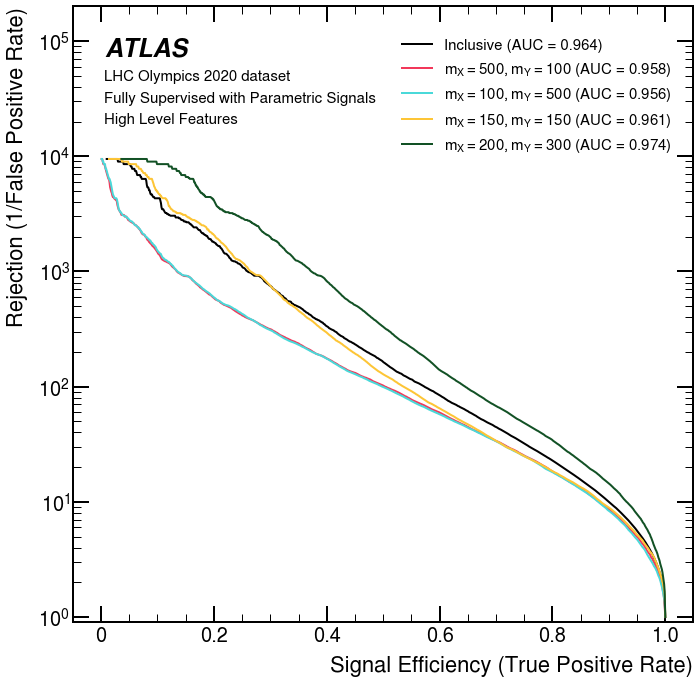

In [11]:
from quickstats.plots import General1DPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'dy': 0.03,
    'dy_main': 0,
    'loc': (0.05, 0.95),
    'extra_text': f'LHC Olympics 2020 dataset//Fully Supervised with Parametric Signals//High Level Features'
}
styles = {
    'figure': {
        'figsize': (11.111, 11.111),
    },
    'legend': {
        'loc': (0.52, 0.75),
        'fontsize': 15
    },
    'text': {
        'fontsize': 15
    }
}
label_map = {}
for mass_point in mass_points:
    roc_auc = aucs[mass_point]
    if mass_point == 'inclusive':
        label = f'Inclusive'
    else:
        m1, m2 = mass_point.split("_")
        label = f'$m_X={m1}, m_Y={m2}$'
    label += f' (AUC = {roc_auc:.3f})'
    label_map[mass_point] = label    
plotter = General1DPlot(dfs, analysis_label_options=analysis_label_options, color_cycle='default', styles=styles, label_map=label_map)    
ax = plotter.draw("tpr", "fpr_inv",
                  logy=True,
                  xlabel="Signal Efficiency (True Positive Rate)",
                  ylabel="Rejection (1/False Positive Rate)",
                  ymax=2e5,
                  ymin=0.9)
#ax.fill_between(tpr_manual, roc_std[0], roc_std[1], color='rust', alpha=0.3)

### Evaluate test metrics

The accuracy does not reflect the fact that most of the events are signals and the background accuracy is actually not good.

In [66]:
accuracy = np.mean(y_true == y_pred)
accuracy

0.9620976930561246

In [67]:
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
fpr, tpr, _ = roc_curve(y_true, predicted_proba.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9644887456338762

In [25]:
from quickstats.utils.common_utils import NpEncoder
import numpy as np
import json
results = {
    'predicted_proba': predicted_proba,
    'y_pred': y_pred,
    'y_true': y_true,
    'accuracy': accuracy,
    'auc': roc_auc,
    'tpr': tpr,
    'fpr': fpr,
    #'bootstrap_predicted_proba': bootstrap_predictions,
    #'bootstrap_y_true': bootstrap_truths,
    #'bootstrap_y_pred': bootstrap_y_pred,
    #'bootstrap_tpr': bootstrap_tpr,
    #'bootstrap_fpr': bootstrap_fpr,
    'bootstrap_accuracy': bootstrap_accuracy,
    'bootstrap_auc': bootstrap_auc,
    'tpr_manual': tpr_manual,
    'roc_median': roc_median,
    'roc_std': roc_std
}
filename = os.path.join(config['checkpoint_dir'], "test_results.json")
json.dump(results, open(filename, "w"), cls=NpEncoder)

In [26]:
import json
import pandas as pd
filename = os.path.join(config['checkpoint_dir'], "metrics_history.json")
metrics_history = json.load(open(filename))
num_epochs = 13
dfs = {}
for key, value in metrics_history.items():
    dfs[key] = pd.DataFrame(value)
    steps_per_epoch = dfs[key].shape[0] // num_epochs
    dfs[key]['epoch'] = (dfs[key].index + 1) / steps_per_epoch

In [27]:
from quickstats.plots import General1DPlot
label_map = {
    'train': 'Train',
    'val': 'Validation'
}
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.1, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Parametric Fully Supervised with High Level Features'
}
styles = {
    'legend': {
        'loc': (0.7, 0.8)
    }
}
plotter = General1DPlot(dfs, color_cycle='checker',
                        label_map=label_map, styles=styles,
                        analysis_label_options=analysis_label_options)

<Axes: xlabel='Epoch', ylabel='Loss'>

<Figure size 640x480 with 0 Axes>

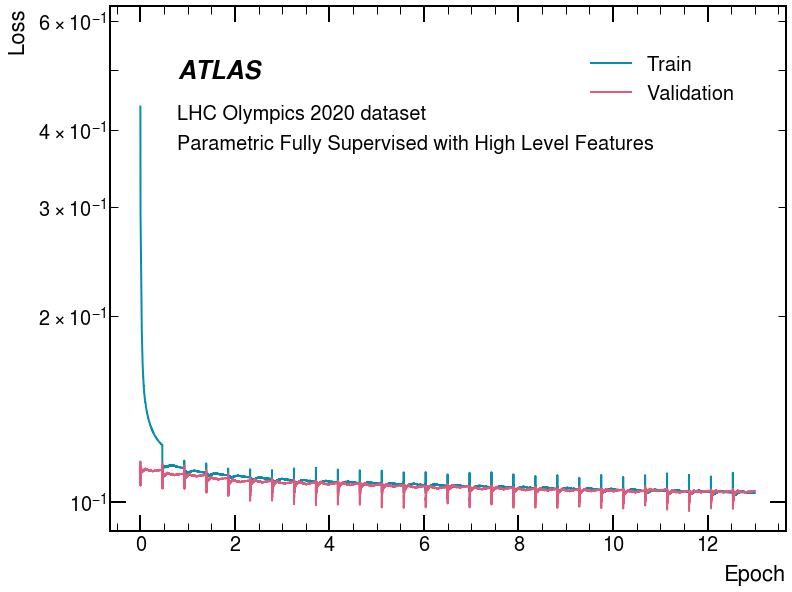

In [28]:
plotter.draw('epoch', 'loss', logy=True, xlabel='Epoch', ylabel='Loss')

<Axes: xlabel='Epoch', ylabel='Accuracy'>

<Figure size 640x480 with 0 Axes>

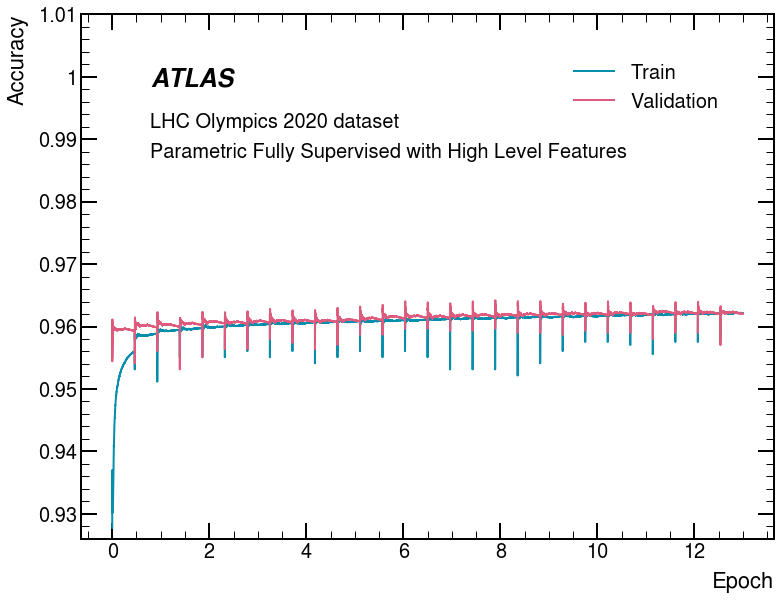

In [29]:
plotter.draw('epoch', 'accuracy', xlabel='Epoch', ylabel='Accuracy', ymax=1.01)

In [30]:
sig_mask = y_true == 1
bkg_mask = y_true == 0
dfs = {
    'Signal'     : pd.DataFrame({"score": predicted_proba.flatten()[sig_mask]}),
    'Background' : pd.DataFrame({"score": predicted_proba.flatten()[bkg_mask]})
}

In [31]:
from quickstats.plots import VariableDistributionPlot
analysis_label_options = {
    'colab': 'ATLAS',
    'status': '', 
    'energy' : None, 
    'lumi' : None,
    'loc': (0.12, 0.9),
    'extra_text': 'LHC Olympics 2020 dataset//Fully Supervised with Low Level Features'
}
styles = {
    'legend': {
        'loc': (0.65, 0.8)
    }
}
plotter = VariableDistributionPlot(dfs, color_cycle='checker',
                                   styles=styles, analysis_label_options=analysis_label_options)

<Axes: xlabel='Predicted Prob.', ylabel='Fraction of Events / 0.04'>

<Figure size 640x480 with 0 Axes>

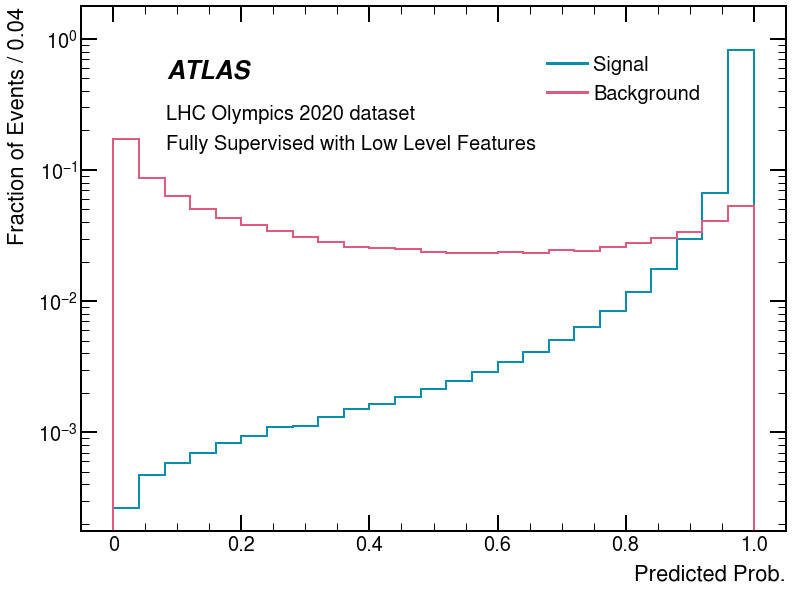

In [32]:
plotter.draw('score', xlabel='Predicted Prob.', bin_range=(0, 1), logy=True)